
# 📓 Colab — Reusar módulos existentes (src/*) y scripts (init/train/explain)

Este notebook **no reescribe lógica**. Reutiliza tus módulos y scripts ya creados:
- `src/utils/io.py`, `src/data/datasets.py`, `src/features/text.py`, `src/models/train.py`, `src/evaluation/plots.py`
- `scripts/init_dataset.py`, `scripts/main_train.py`, `scripts/run_explain.py`

Flujo:
1) Montar Google Drive y apuntar `PROJECT_ROOT` a la carpeta del proyecto (donde vive `src/` y `configs/`).  
2) Instalar dependencias mínimas.  
3) **Cargar y probar imports** desde `src/*`.  
4) Ejecutar **init dataset** (opcional, según tu `config_default.yaml`).  
5) Ejecutar **entrenamiento** (TF‑IDF + modelo según config).  
6) Ejecutar **explicabilidad** (LIME + SHAP) y **visualizar** salidas (PNG/HTML).

> Ajusta la ruta de `PROJECT_ROOT` en la celda 1 para que apunte a tu proyecto en Drive.


In [22]:

# 1) Montar Drive y fijar PROJECT_ROOT  🔧
from google.colab import drive
from pathlib import Path
import sys

drive.mount('/content/drive')

# 👉 Cambia esta ruta a la carpeta de TU proyecto en Drive (donde están src/, scripts/, configs/)
PROJECT_ROOT = Path("/content/drive/MyDrive/EspecialidadMachineLearning/Modulo9Clase1MarcoParra").resolve()
assert PROJECT_ROOT.exists(), f"No existe PROJECT_ROOT: {PROJECT_ROOT}"

# Asegura que Python vea tu paquete src/*
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)
!ls -lah "{PROJECT_ROOT}"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_ROOT: /content/drive/MyDrive/EspecialidadMachineLearning/Modulo9Clase1MarcoParra
total 14M
-rw------- 1 root root 176K Sep  3 19:52 'ACTIVIDAD SESIÓN 1.pdf'
drwx------ 2 root root 4.0K Sep 10 17:24  configs
drwx------ 2 root root 4.0K Sep 10 17:24  env
-rw------- 1 root root  133 Sep  9 15:12  .gitignore
-rw------- 1 root root  16K Sep  9 15:12  init_project.sh
-rw------- 1 root root  14M Sep  3 17:20  MLM9S1-presentacion.pptx
drwx------ 2 root root 4.0K Sep 10 18:08  models
drwx------ 2 root root 4.0K Sep 10 17:53  notebooks
-rw------- 1 root root  219 Sep  9 15:12  README.md
drwx------ 3 root root 4.0K Sep 10 18:08  reports
-rw------- 1 root root   64 Sep  9 15:12  requirements.txt
drwx------ 2 root root 4.0K Sep 10 17:24  scripts
drwx------ 8 root root 4.0K Sep 10 17:24  src


In [2]:

# 2) Dependencias mínimas (CPU)
!pip -q install --upgrade pip
!pip -q install numpy pandas scikit-learn matplotlib seaborn
!pip -q install lime shap datasets joblib
# (Solo si luego usarás Transformers)
# !pip -q install transformers sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [7]:

# 3) Importar tus módulos (src/*) para validar que todo esté OK
from src.utils.io import load_yaml, ensure_dir, save_json
from src.data.datasets import load_dataset
from src.features.text import build_vectorizer
from src.models.train import split_xy, get_model, evaluate
from src.evaluation.plots import plot_confusion

# Mostrar partes clave de la config
CFG_PATH = PROJECT_ROOT / "configs" / "config_default.yaml"
cfg = load_yaml(CFG_PATH)
cfg


{'project': {'seed': 42,
  'output_dir': 'reports',
  'logs_dir': 'reports/logs',
  'figures_dir': 'reports/figures',
  'explain_dir': 'reports/figures/explainability',
  'runs_dir': 'reports/runs'},
 'dataset': {'source': 'huggingface',
  'hf_name': 'imdb',
  'text_col': 'text',
  'label_col': 'label',
  'max_samples_train': 2000,
  'max_samples_test': 1000,
  'csv_path': 'data/raw/opiniones.csv',
  'simulate_min': 200},
 'preprocessing': {'lowercase': True,
  'remove_punct': True,
  'remove_numbers': False,
  'stopwords': 'english',
  'ngram_range': [1, 2],
  'max_features': 20000},
 'model': {'name': 'logreg',
  'logreg': {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 200},
  'random_forest': {'n_estimators': 300,
   'max_depth': None,
   'class_weight': 'balanced'}},
 'training': {'test_size': 0.2, 'stratify': True, 'scoring': 'f1'},
 'explain': {'lime_samples': 2, 'shap_samples': 2, 'topk': 10}}

In [11]:

# 4) (Opcional) Inicializar/descargar dataset usando tu propio script
#    Respetará la configuración en configs/config_default.yaml
!python "{PROJECT_ROOT/'scripts/init_dataset.py'}" --config "{PROJECT_ROOT/'configs/config_default.yaml'}" --export_csv


/content/drive/MyDrive/EspecialidadMachineLearning/Modulo9Clase1MarcoParra
OK — entrenamiento listo. Métricas en reports/, artefactos en models/


In [12]:

# 5) Entrenamiento usando tu script main_train.py
#    - Guarda metrics en reports/
#    - Confusion matrix en reports/figures/
#    - Artefactos (vectorizer/model) en models/
%cd "{PROJECT_ROOT}"
!python scripts/main_train.py --config configs/config_default.yaml



/content/drive/MyDrive/EspecialidadMachineLearning/Modulo9Clase1MarcoParra
OK — entrenamiento listo. Métricas en reports/, artefactos en models/


Accuracy: 0.8516666666666667
F1-macro: 0.851656365025349
Reporte por clase:
        neg | P=0.875 R=0.832 F1=0.853 support=310.0
        pos | P=0.830 R=0.872 F1=0.850 support=290.0
  macro avg | P=0.852 R=0.852 F1=0.852 support=600.0
 weighted avg | P=0.853 R=0.852 F1=0.852 support=600.0


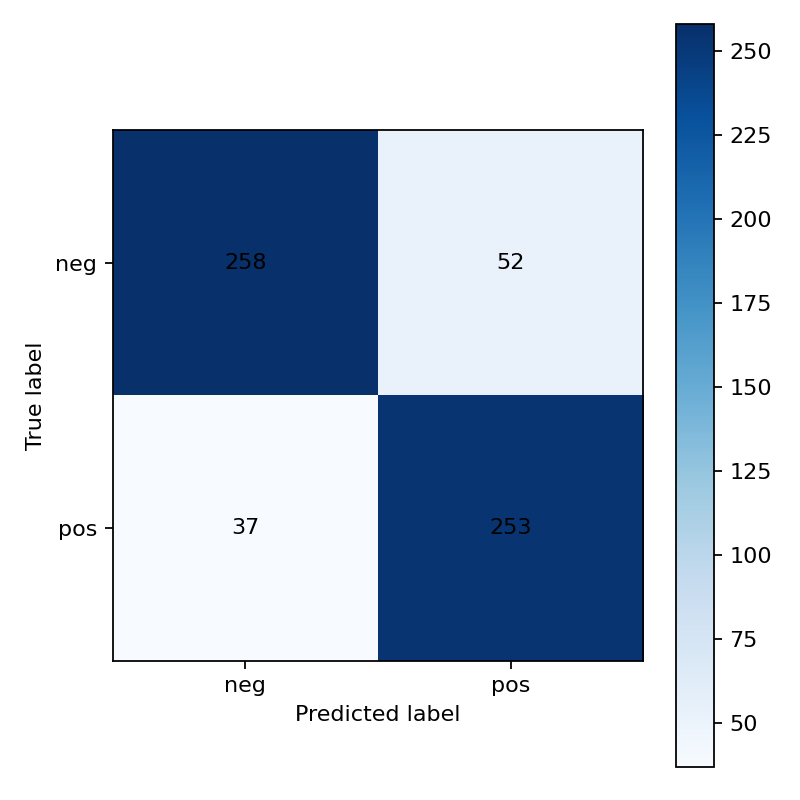

In [13]:

# 6) Cargar y visualizar métricas y matriz de confusión
import json, matplotlib.pyplot as plt
from PIL import Image

metrics_path = PROJECT_ROOT / "reports" / "metrics_cls.json"
with open(metrics_path, "r", encoding="utf-8") as f:
    metrics = json.load(f)
print("Accuracy:", metrics.get("accuracy"))
print("F1-macro:", metrics.get("f1_macro"))
print("Reporte por clase:")
for k, v in metrics.get("report", {}).items():
    if isinstance(v, dict) and "precision" in v:
        print(f" {k:>10} | P={v['precision']:.3f} R={v['recall']:.3f} F1={v['f1-score']:.3f} support={v['support']}")

cm_png = PROJECT_ROOT / "reports" / "figures" / "confusion_matrix.png"
display(Image.open(cm_png))


In [23]:

# 7) Explicabilidad: LIME y SHAP con tu script run_explain.py
#    - Genera LIME HTML + PNG y SHAP PNG en reports/figures/explainability
%cd "{PROJECT_ROOT}"
!python scripts/run_explain.py --config configs/config_default.yaml --method both --samples 3


/content/drive/MyDrive/EspecialidadMachineLearning/Modulo9Clase1MarcoParra
OK — explicaciones guardadas en reports/figures/explainability


PNG encontrados: ['lime_ex_0.png', 'lime_ex_1.png', 'lime_ex_2.png', 'lime_ex_3.png', 'lime_ex_4.png', 'shap_ex_0.png', 'shap_ex_1.png', 'shap_ex_2.png']


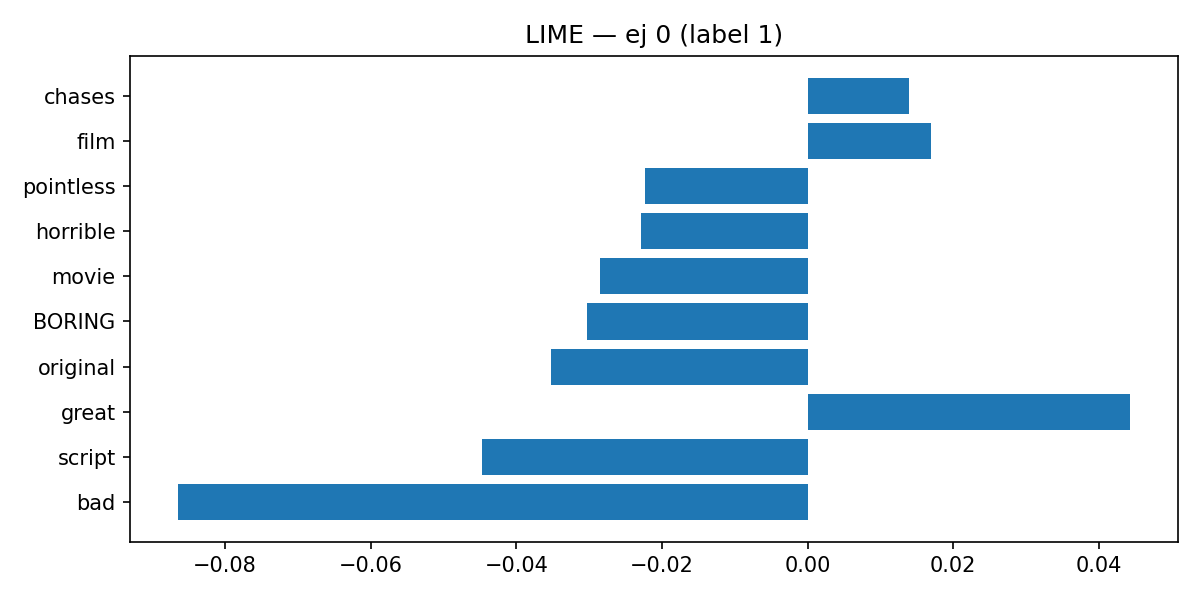

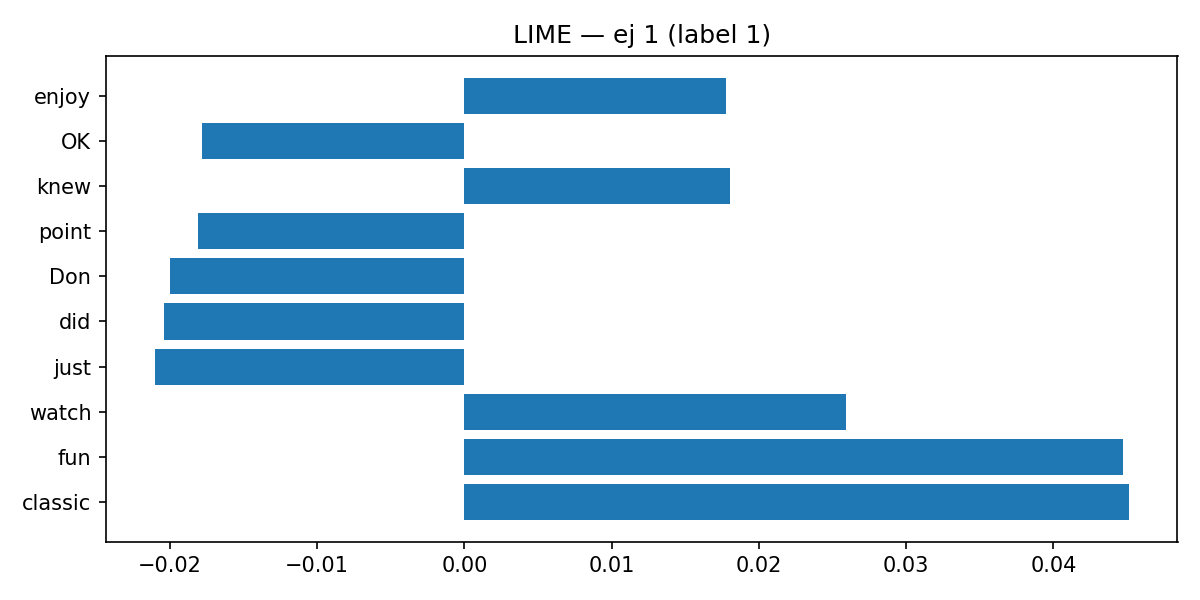

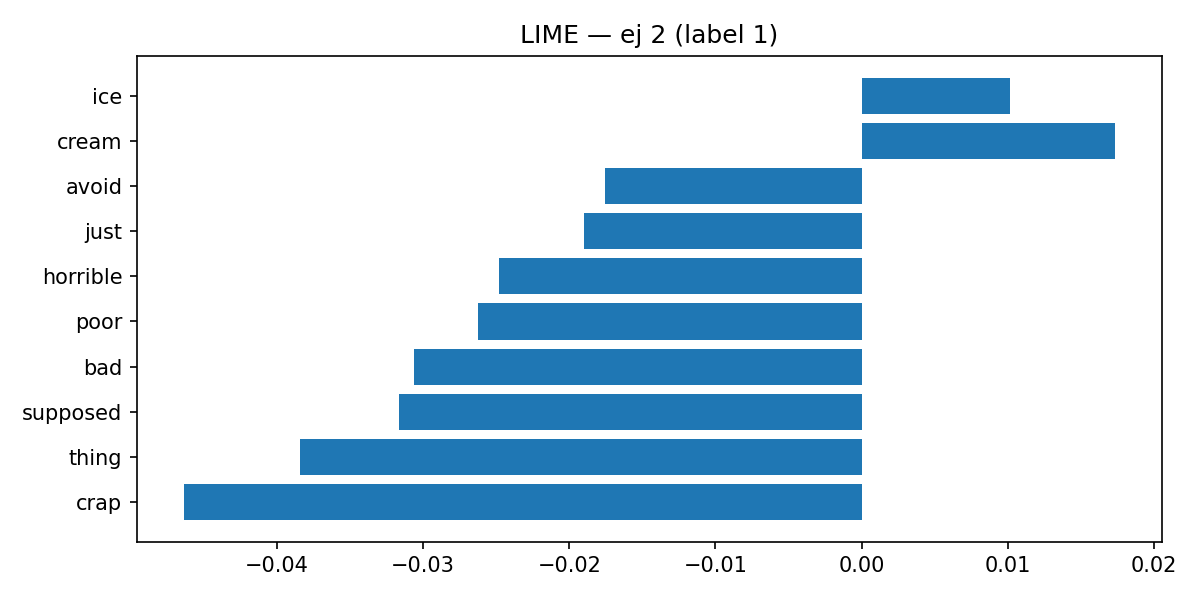

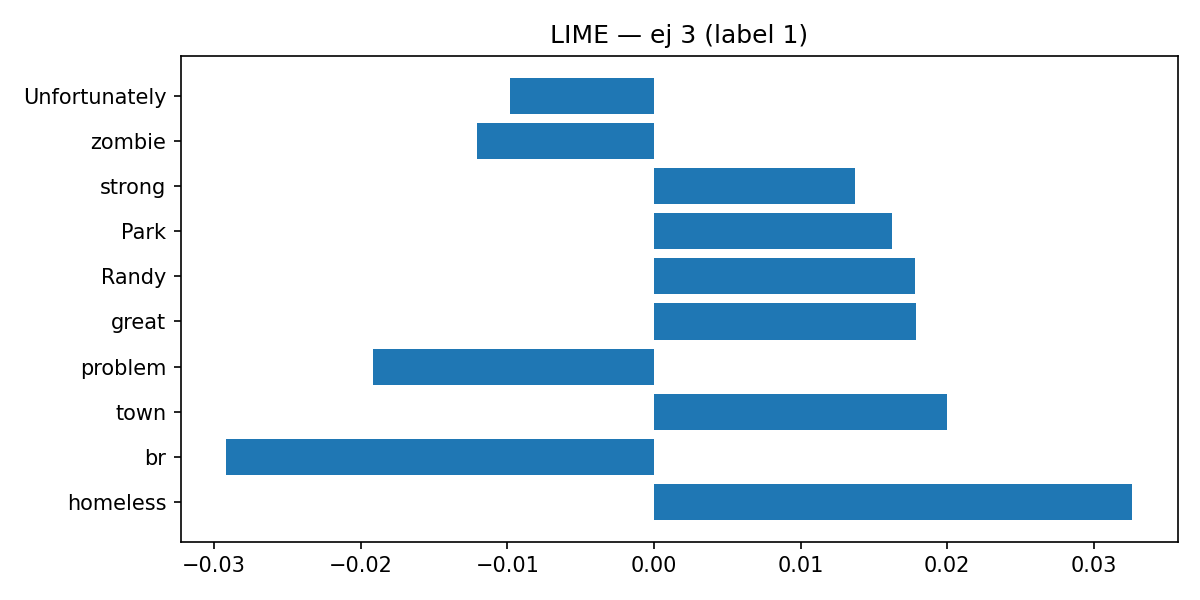

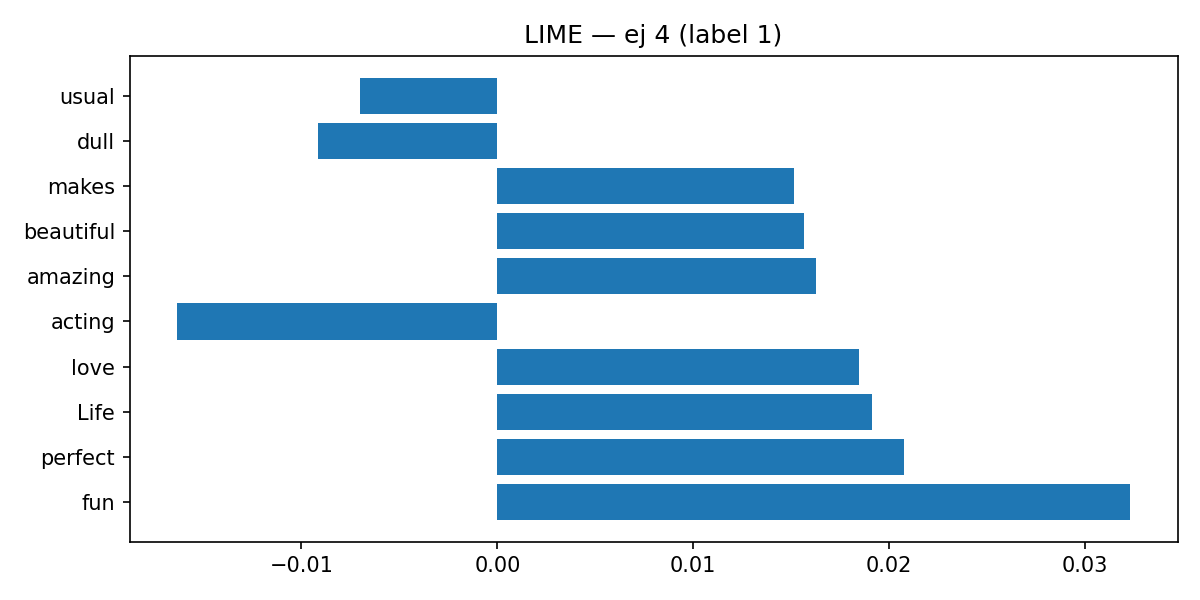

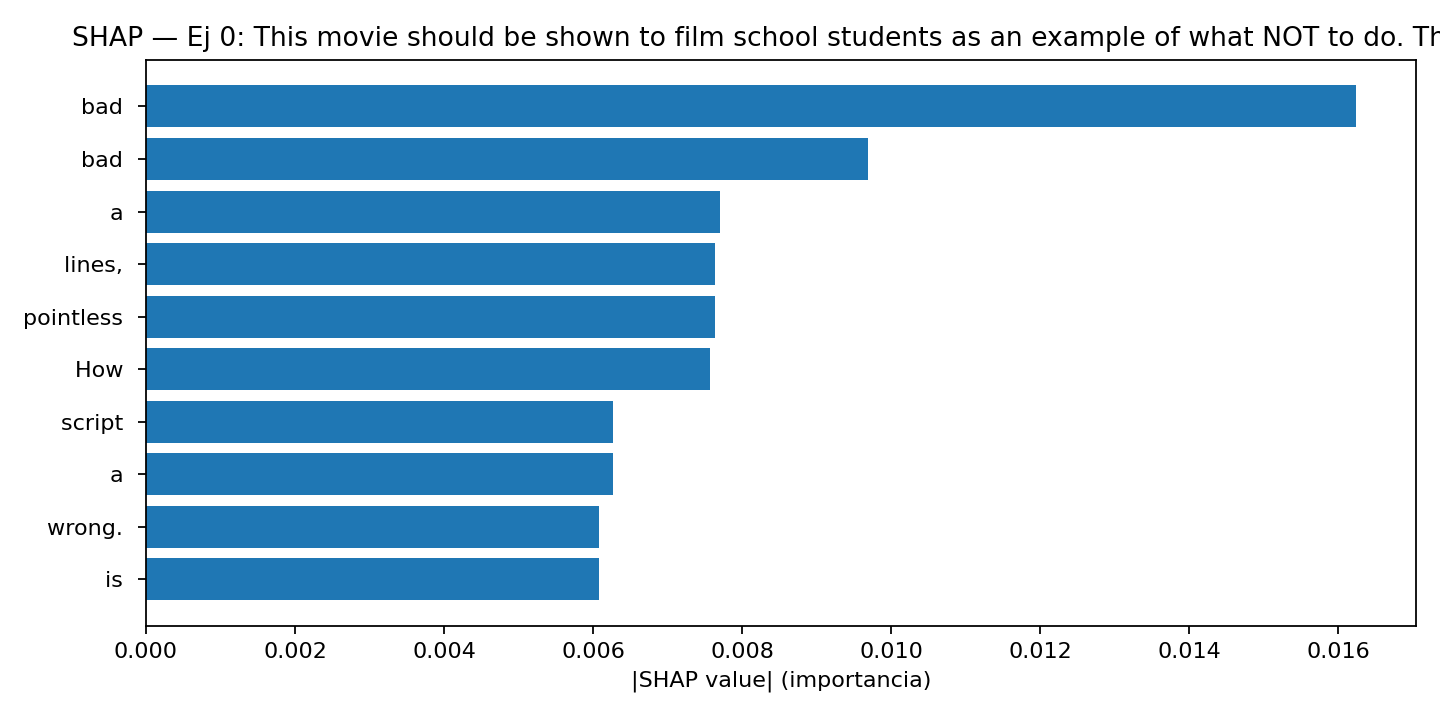

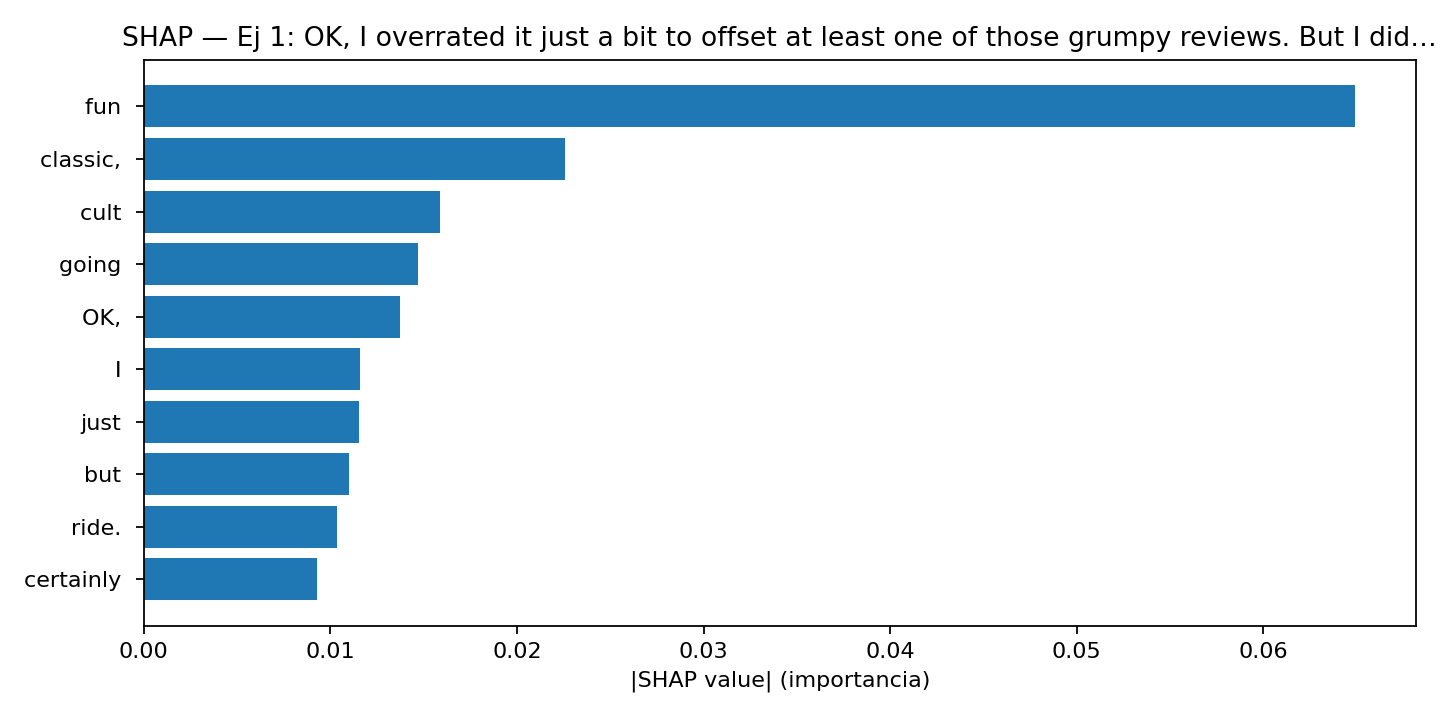

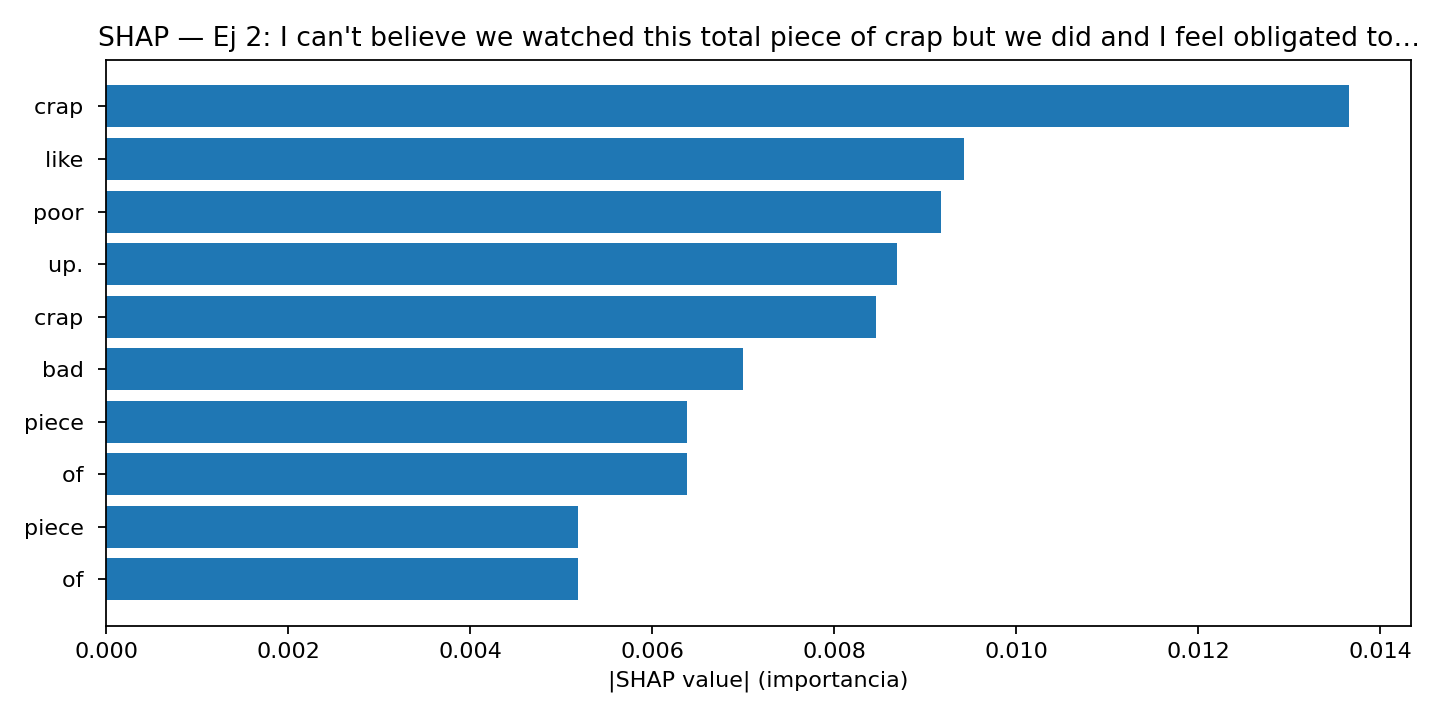

HTML: /content/drive/MyDrive/EspecialidadMachineLearning/Modulo9Clase1MarcoParra/reports/figures/explainability/lime_ex_0.html


HTML: /content/drive/MyDrive/EspecialidadMachineLearning/Modulo9Clase1MarcoParra/reports/figures/explainability/lime_ex_1.html


HTML: /content/drive/MyDrive/EspecialidadMachineLearning/Modulo9Clase1MarcoParra/reports/figures/explainability/lime_ex_2.html


HTML: /content/drive/MyDrive/EspecialidadMachineLearning/Modulo9Clase1MarcoParra/reports/figures/explainability/lime_ex_3.html


HTML: /content/drive/MyDrive/EspecialidadMachineLearning/Modulo9Clase1MarcoParra/reports/figures/explainability/lime_ex_4.html


In [24]:

# 8) Visualizar outputs de explicabilidad (PNG) en el notebook
from pathlib import Path
from IPython.display import display, HTML

exp_dir = PROJECT_ROOT / "reports" / "figures" / "explainability"
pngs = sorted(exp_dir.glob("*.png"))
print("PNG encontrados:", [p.name for p in pngs])
for p in pngs:
    display(Image.open(p))

# LIME HTML (se listan como enlaces clicables dentro de Colab)
htmls = sorted(exp_dir.glob("lime_ex_*.html"))
for h in htmls:
    print("HTML:", h)
    display(HTML(f'<a href="file://{h}" target="_blank">{h.name}</a>'))
